In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import math
import pywt
import scipy
from scipy import ndimage
from sklearn.metrics import silhouette_score, calinski_harabaz_score
import matplotlib.colors as color

In [699]:
import random

In [2]:
#Change viewing options
from IPython.core.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

In [3]:
#from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
#client

In [4]:
#Bring in the whole dataset
start = time.time()
ds = xr.open_mfdataset('/Users/ddesantis/Downloads/livneh_NAmerExt_15Oct2014.*.mon.nc', autoclose=True)
end = time.time()
print(end - start)

11.4480941296


In [730]:
#Grab data for graphing
lat_space = np.linspace(start = np.min(ds.lat.data), stop = np.max(ds.lat.data), num = 7)
lat_space = np.round(lat_space, decimals = 1)
lon_space = np.linspace(start = np.min(ds.lon.data), stop = np.max(ds.lon.data), num = 7)
lon_space = np.round(lon_space, decimals = 1)

In [1000]:
label_sets = np.load('label_sets.npy')

In [1001]:
nan_mask_slice = np.load('nan_mask_slice.npy')

In [1162]:
#Collect keys from the label_sets:
label_set_keys = label_sets[()].keys()

num_clusterings = max(label_set_keys)+1

# Plotting Clusters

In [1163]:
#The purpose for this part of the code is to plot the raw clustering obtained using the same color bar.

In [1164]:
#This cell builds a colormap to be used for plotting the combined clusterings:

#Find the largest number of colors needed
color_counter = []
for i in range(num_clusterings):
    color_counter.append(np.max(label_sets[()][i]))
    
color_count = np.max(color_counter)

#Produce colorbar:

#Take a cube root of the largest number of colors needed to split across RBG
k = np.ceil(int(color_count)**(.3333))

#Build the numpy array of the evenly spaced colors
c_space = np.linspace(0,1,k)
l = c_space.size
colormap = np.zeros((l**3,3))

index= -1
for i in range(l):
    for j in range(l):
        for k in range(l):
            index+=1
            colormap[index] = [c_space[i],c_space[j],c_space[k]]

#This produces too many colors - in particular it includes the color of (1,1,1) reserved for the nan values.  
#Randomize to subset-take only as many as needed
color_ind = random.sample(range(l**3-1), int(color_count))
color_ind = np.array(color_ind)
colormap = colormap[color_ind,:]

/Users/ddesantis/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


In [1165]:
#For plotting, we need to add the nan_mask.
plot_sets = {}
for i in range(num_clusterings):
    plot_sets[i] = label_sets[()][i] + nan_mask_slice

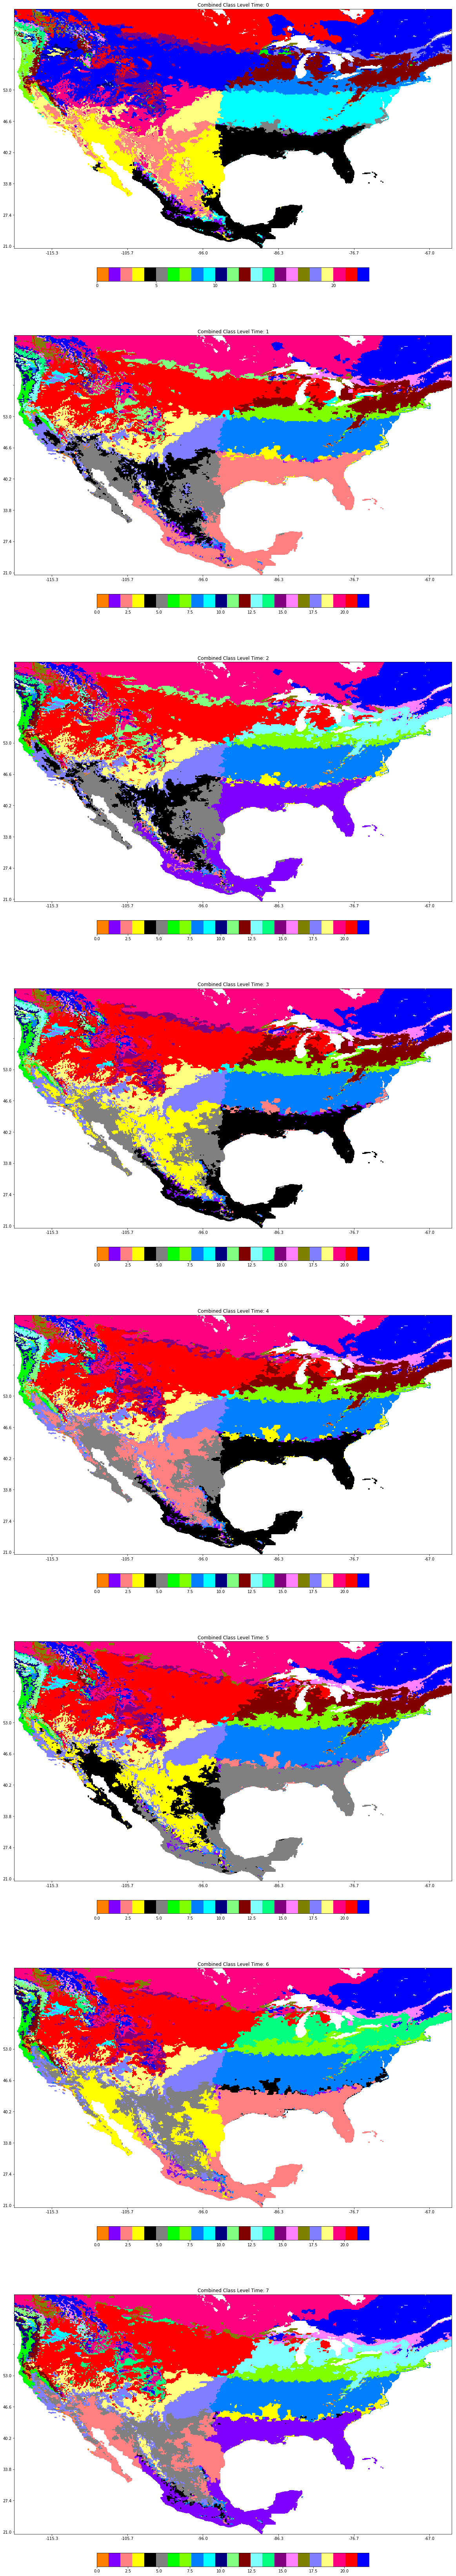

In [1166]:
#Plot each of the combined clusters:

f, ax = plt.subplots(figsize=(20, 15*8), ncols=1, nrows=8)

for i in range(num_clusterings):
    number_labels = np.nanmax(plot_sets[i])    
    cmap = color.ListedColormap(colormap)
    p0 = ax[i].pcolormesh(ds.lon, ds.lat, plot_sets[i], vmin=0, vmax=number_labels, cmap=cmap)
    #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    plt.colorbar(p0, ax=ax[i], orientation='horizontal',
                 pad=0.07, fraction=0.05)
    #p.clim(0, number_labels)
    ax[i].set_title('Combined Class Level Time: ' + str(i))

    ax[i].set_xticklabels(lon_space, minor=False)
    ax[i].set_yticklabels(lat_space, minor=False)

plt.show()

# Cluster Tracking

In [ ]:
#Clearly, some cluster numbers got switched in this process.  This part of the code aims to correct the cluster label mismatch.

In [603]:
def create_locs(classes):
    '''
    Finds the (x,y) location of the class and returns a dictionary with classes and locations
    '''
    #First we prep data to remove the inf
    #classes = classes+1
    #classes = np.nan_to_num(classes)
    
    #Find locs
    t_loc = {}
    for i in np.unique(classes):
        t_loc[i] = np.argwhere(classes==i)
        
    return t_loc

In [322]:
def count_intersection(class1,class2):
    """
    Given two arrays of coordinate points, count the intersection between them
    """
    
    counter = 0
    for i in range(class1.shape[0]):
        if np.any((class2==class1[i]).all(1)):
            counter+=1
            
    return counter

In [323]:
def edge_weight(class1, class2):
    """
    Given two classes from time 1 and time 2, compute the edge weight
    """
    
    intersect = count_intersection(class1,class2)
    edge = float(intersect)/float(class2.shape[0])
    
    return edge

In [1167]:
def cluster_tracking(t1_loc,t2_loc):
    '''
    Given the dicts of class/locations, compute the cluster tracking matrix
    '''
    start = time.time()
    num_class1 = len(t1_loc.keys())
    num_class2 = len(t2_loc.keys())
    
    E = np.zeros((num_class1-1,num_class2-1))
    
    for key1 in np.sort(t1_loc.keys())[1:]:  #this lists all the keys in order, skipping the nan class -1
        print("Class: " + str(key1))
        for key2 in np.sort(t2_loc.keys())[1:]:
            E[int(key1),int(key2)] = edge_weight(t1_loc[key1],t2_loc[key2])
    end=time.time()
    print("Tracking Time: " + str(end-start))
    print("")
    
    
    return E

# Test on Real Data

In [585]:
#Create a dictionary of the clusterings
clusters = {}
for i in range(num_clusterings):
    clusters[i] = label_sets[()][i]

In [604]:
#Given a clustering, find the locations of each cluster value
t_loc = {}
for i in range(num_clusterings):
    t_loc[i] = create_locs(clusters[i])

In [1168]:
cluster_tracking(t_loc[0], t_loc[1])

Class: 0.0
Class: 1.0
Class: 2.0
Class: 3.0
Class: 4.0
Class: 5.0
Class: 6.0
Class: 7.0
Class: 8.0
Class: 9.0
Class: 10.0
Class: 11.0
Class: 12.0
Class: 13.0
Class: 14.0
Class: 15.0
Class: 16.0
Class: 17.0
Class: 18.0
Class: 19.0
Class: 20.0
Class: 21.0
Class: 22.0
Class: 23.0
Tracking Time: 344.299990892



array([[0.647, 0, 0, 0.000637, 0, 0.000933, 0.00161, 0, 0.0018, 0, 0, 0, 0.0013, 0.0107, 0, 0, 0, 0, 0, 0.00423, 0, 0, 0],
       [0, 0.846, 0.00537, 0.00127, 0.0102, 0.00056, 0, 0, 0.00309, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0.0151, 0, 0, 0.92, 0.0155, 0, 0, 0.000129, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0309, 0.000793, 0, 0, 0],
       [0.00603, 0.00336, 0.0173, 0, 0.0517, 0.967, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.000473, 0, 0, 0, 0],
       [0, 0.068, 0.974, 0.132, 0, 0.0158, 0, 0, 0.000772, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0.00302, 0, 0.00341, 0.809, 0, 0, 0, 0, 0.00727, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0.196, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0396, 0.00181, 0, 0, 0, 0, 0, 0, 0, 0.000558, 0.00071, 0.00139],
       [0.00302, 0, 0, 0, 0, 0, 0.89, 0, 0.000161, 0, 0.00484, 0, 0, 0, 0, 0, 0, 0, 0.00118, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0.929, 0.00196, 0.258, 0.00242, 0, 0.0167, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0.0211, 0.0621

In [1172]:
#Takes 344 seconds per run
#Time to run this on all time slices (((44)*344)/60)/60

4

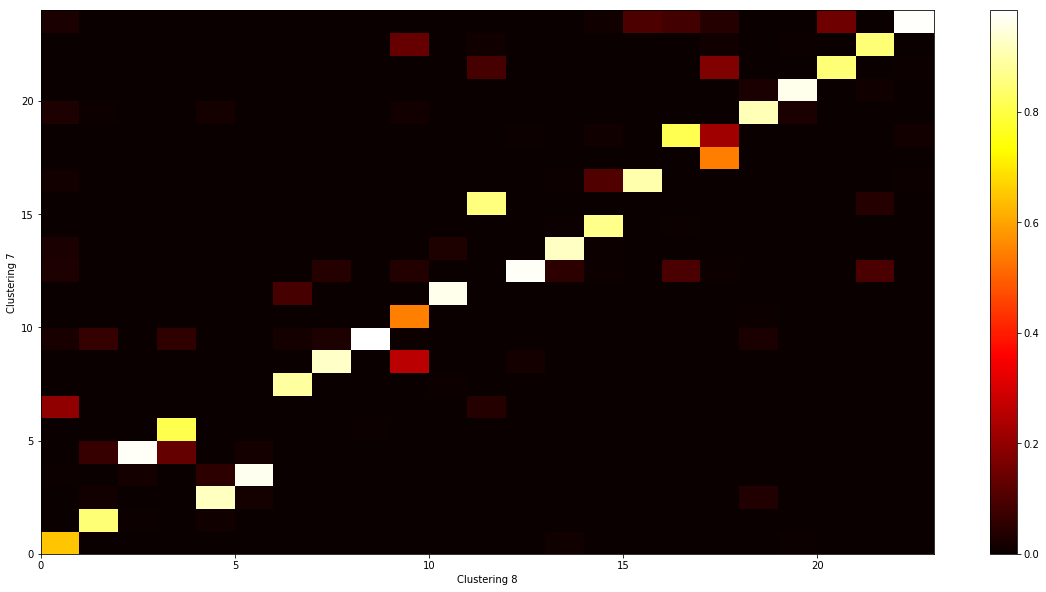

In [1178]:
plt.figure(figsize=(20,10))
#p0= plt.pcolormesh(tracking[(i,i+1)], cmap="hot")
p0 = plt.pcolormesh(tracking[0,1], cmap="hot")
plt.colorbar(p0)
plt.ylabel("Clustering " + str(i))
plt.xlabel("Clustering " + str(i+1))
plt.show()

In [782]:
#Track how the clusters change from one clustering to the next
tracking = {}
for i in range(num_clusterings-1):
    E = cluster_tracking(t_loc[i], t_loc[i+1])
    tracking[(i,i+1)] = E

Class: 0.0
Class: 1.0
Class: 2.0
Class: 3.0
Class: 4.0
Class: 5.0
Class: 6.0
Class: 7.0
Class: 8.0
Class: 9.0
Class: 10.0
Class: 11.0
Class: 12.0
Class: 13.0
Class: 14.0
Class: 15.0
Class: 16.0
Class: 17.0
Class: 18.0
Class: 19.0
Class: 20.0
Class: 21.0
Class: 22.0
Class: 23.0
Class: 0.0
Class: 1.0
Class: 2.0
Class: 3.0
Class: 4.0
Class: 5.0
Class: 6.0
Class: 7.0
Class: 8.0
Class: 9.0
Class: 10.0
Class: 11.0
Class: 12.0
Class: 13.0
Class: 14.0
Class: 15.0
Class: 16.0
Class: 17.0
Class: 18.0
Class: 19.0
Class: 20.0
Class: 21.0
Class: 22.0
Class: 0.0
Class: 1.0
Class: 2.0
Class: 3.0
Class: 4.0
Class: 5.0
Class: 6.0
Class: 7.0
Class: 8.0
Class: 9.0
Class: 10.0
Class: 11.0
Class: 12.0
Class: 13.0
Class: 14.0
Class: 15.0
Class: 16.0
Class: 17.0
Class: 18.0
Class: 19.0
Class: 20.0
Class: 21.0
Class: 22.0
Class: 0.0
Class: 1.0
Class: 2.0
Class: 3.0
Class: 4.0
Class: 5.0
Class: 6.0
Class: 7.0
Class: 8.0
Class: 9.0
Class: 10.0
Class: 11.0
Class: 12.0
Class: 13.0
Class: 14.0
Class: 15.0
Class: 1

Before


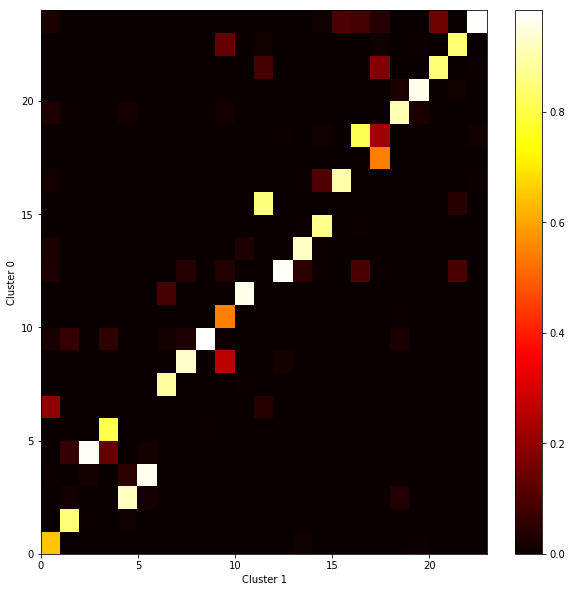

After


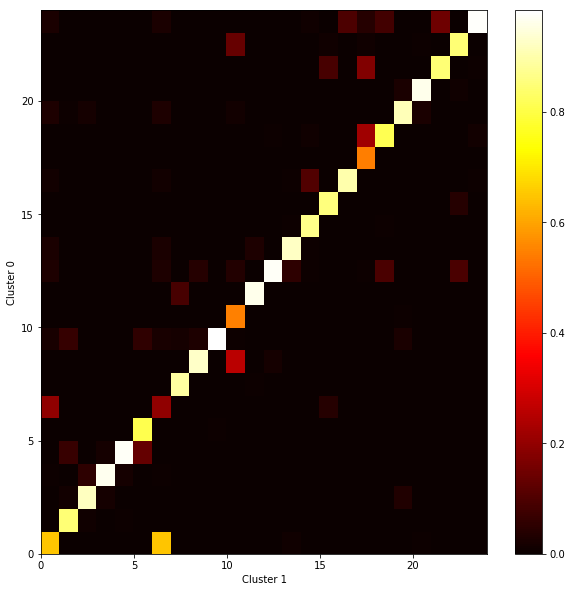

Before


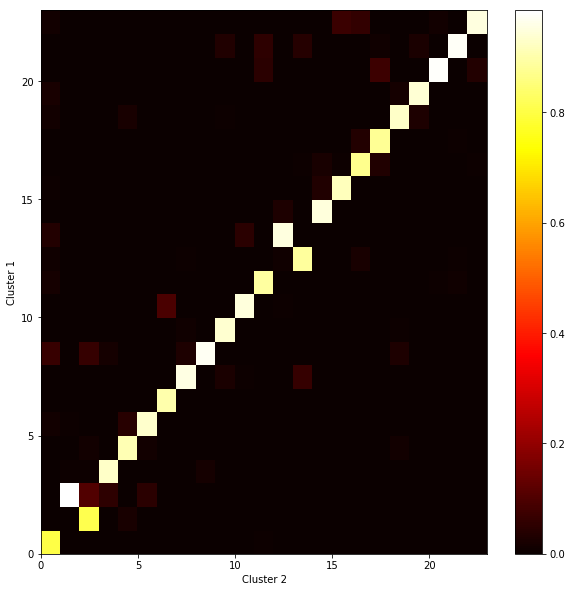

After


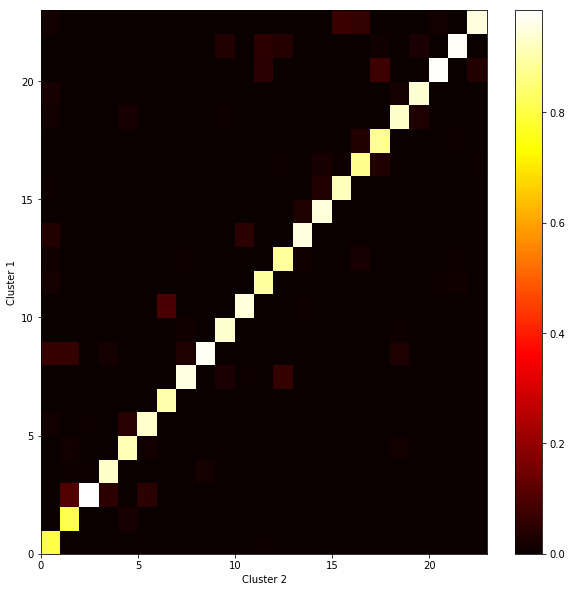

Before


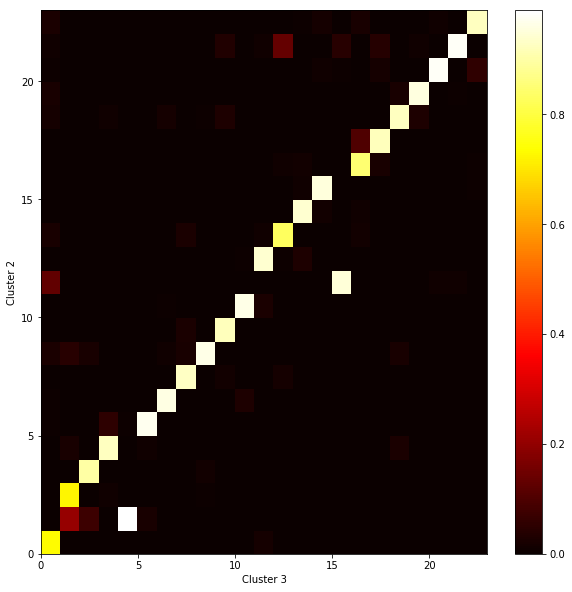

After


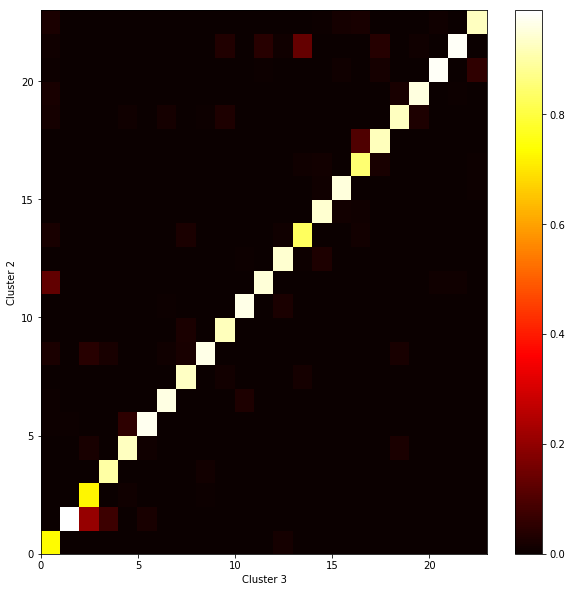

Before


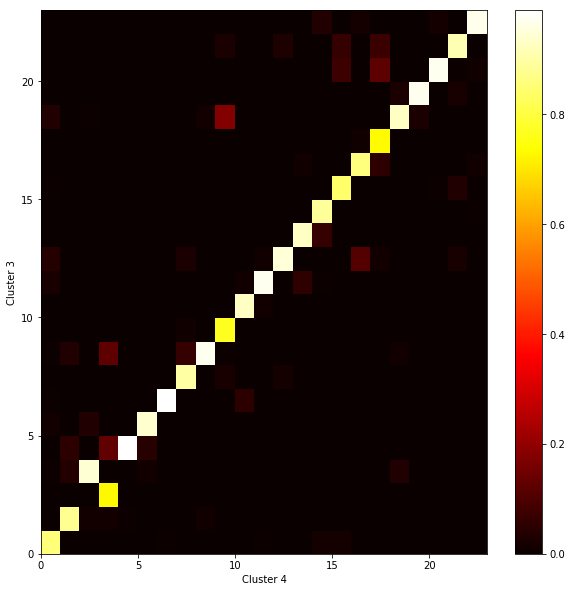

After


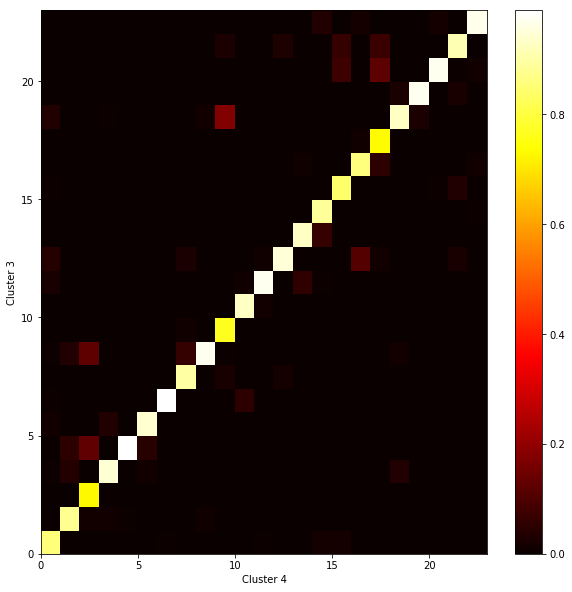

Before


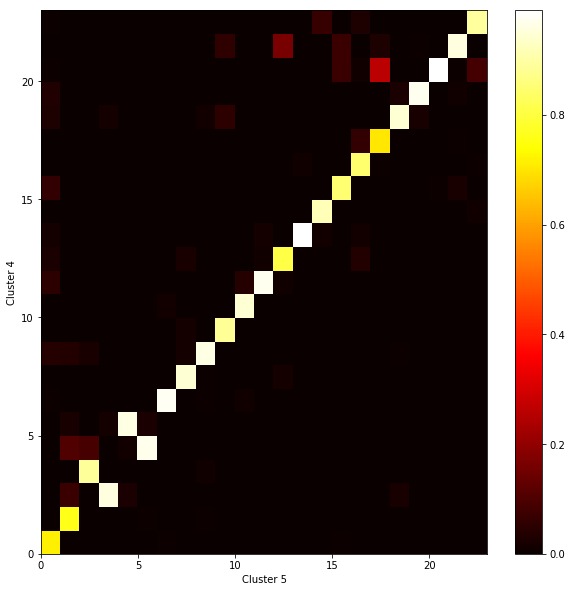

After


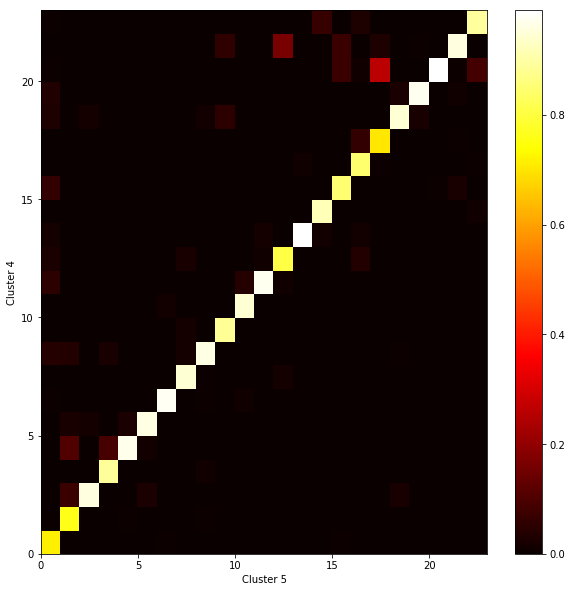

Before


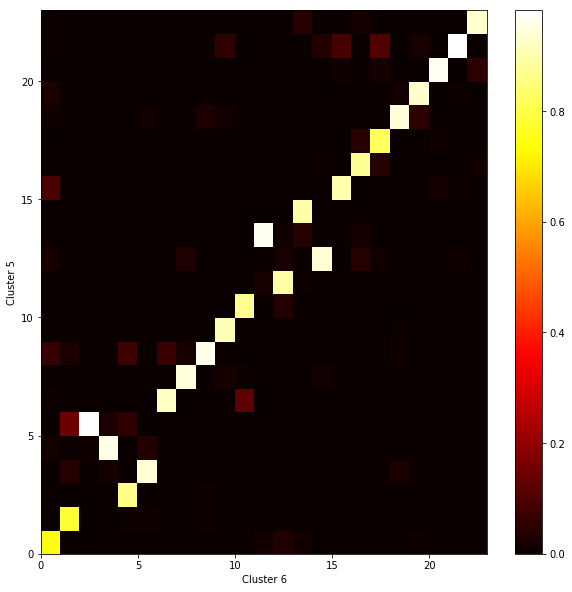

After


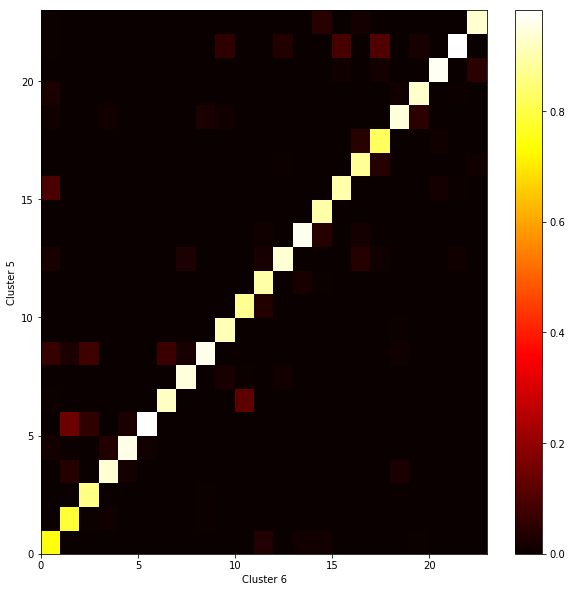

Before


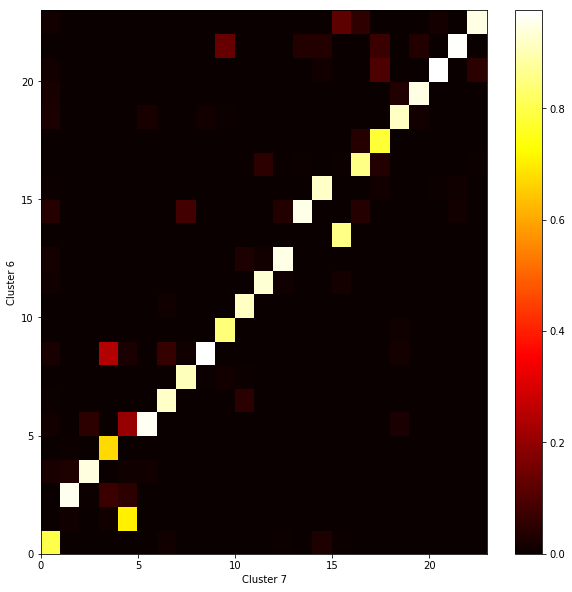

After


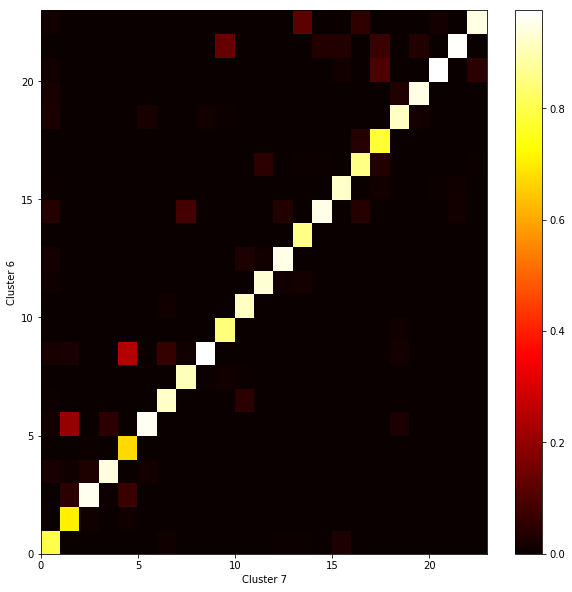

In [904]:
#Here we find out how to re-index based off the maximum value along the rows. 
#We also plot the heat maps before and after reindexing

re_ind = {}
for i in range(num_clusterings-1):
    ind = np.argmax(tracking[(i,i+1)],axis=1)
    re_ind[i] = ind
    ordered = tracking[(i,i+1)][:,ind]
    
    print("Before")
    
    plt.figure(figsize=(20,10))
    p0= plt.pcolormesh(tracking[(i,i+1)], cmap="hot")
    plt.colorbar(p0)
    plt.ylabel("Clustering " + str(i))
    plt.xlabel("Clustering " + str(i+1))
    plt.show()
    
    print("After")
    
    plt.figure(figsize=(20,10))
    p= plt.pcolormesh(ordered, cmap="hot")
    plt.colorbar(p)
    plt.ylabel("Clustering " + str(i))
    plt.xlabel("Clustering " + str(i+1))
    plt.show()
    
    

In [1103]:
#Here we create a new labelling to compare between the two time steps
compare_label = {}
for j in range(num_clusterings-1):
    #insert a -1 into the zero'th slot of re_ind[j]
    temp_ind = np.insert(re_ind[j],0,-1)
    temp_label = np.copy(label_sets[()][j])
    save_unique = np.copy(np.unique(label_sets[()][j]))
    for i in range(np.unique(label_sets[()][j]).size):
        #replace the class i in j'th time chunk with the new labels
        temp_label[label_sets[()][j] == np.unique(save_unique[i])] = temp_ind[i] 
    
    compare_label[j] = temp_label+nan_mask_slice

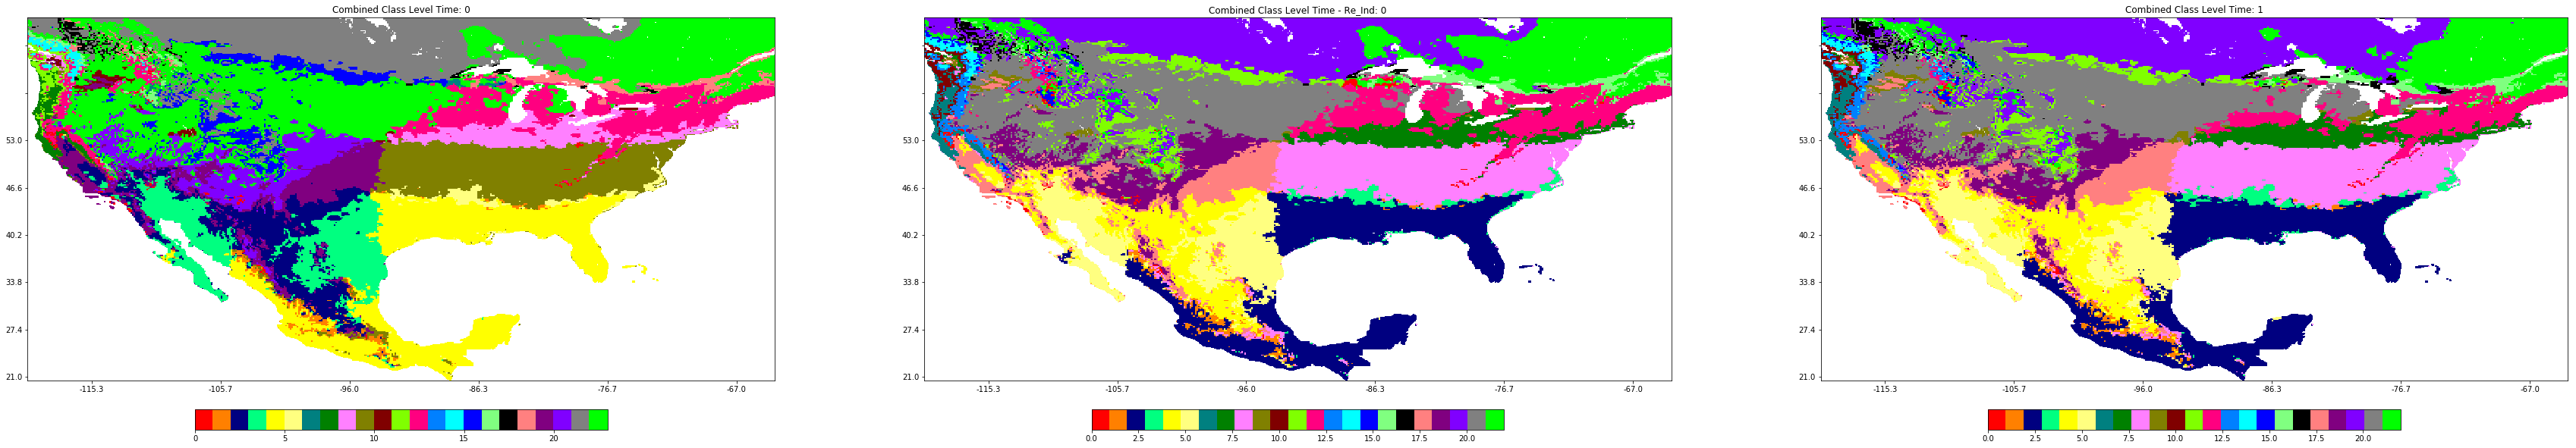

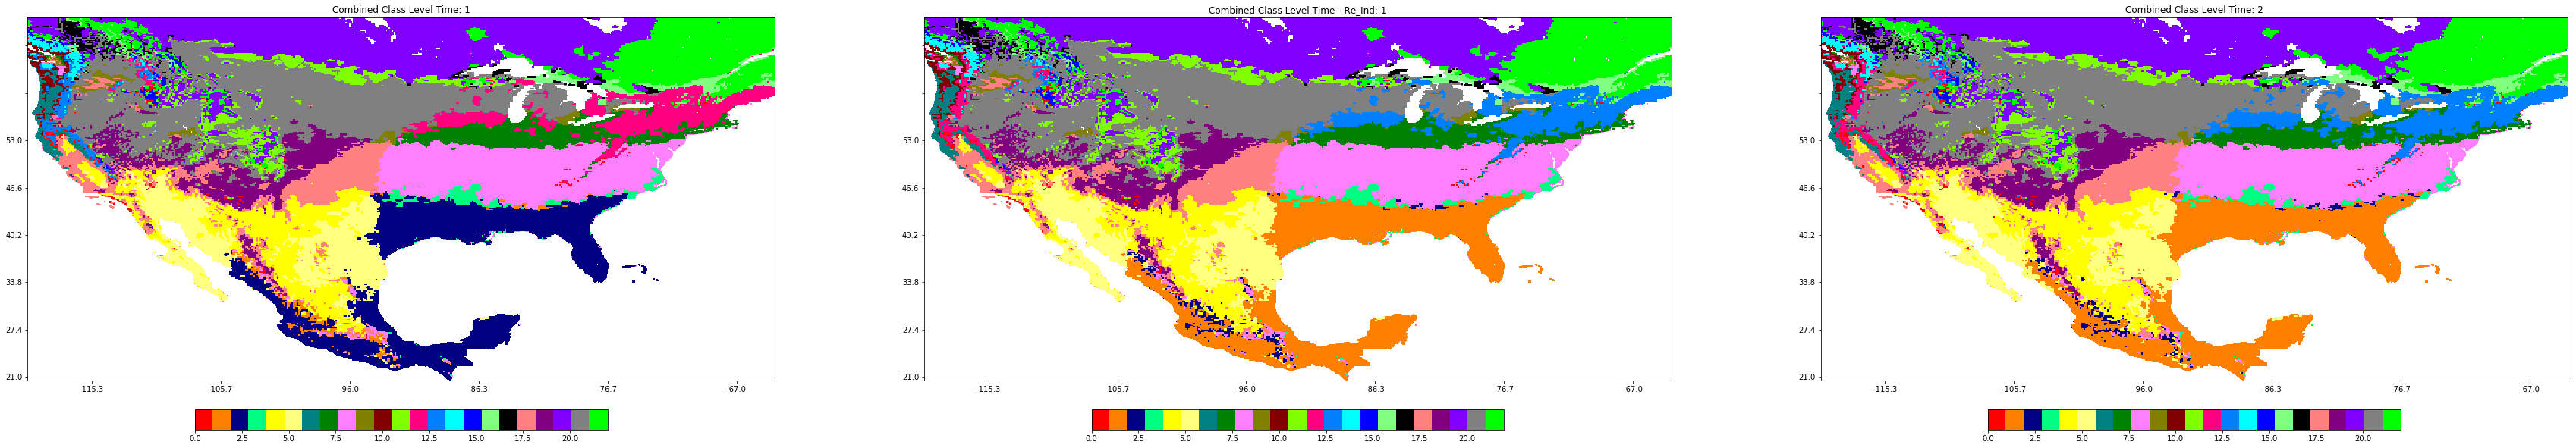

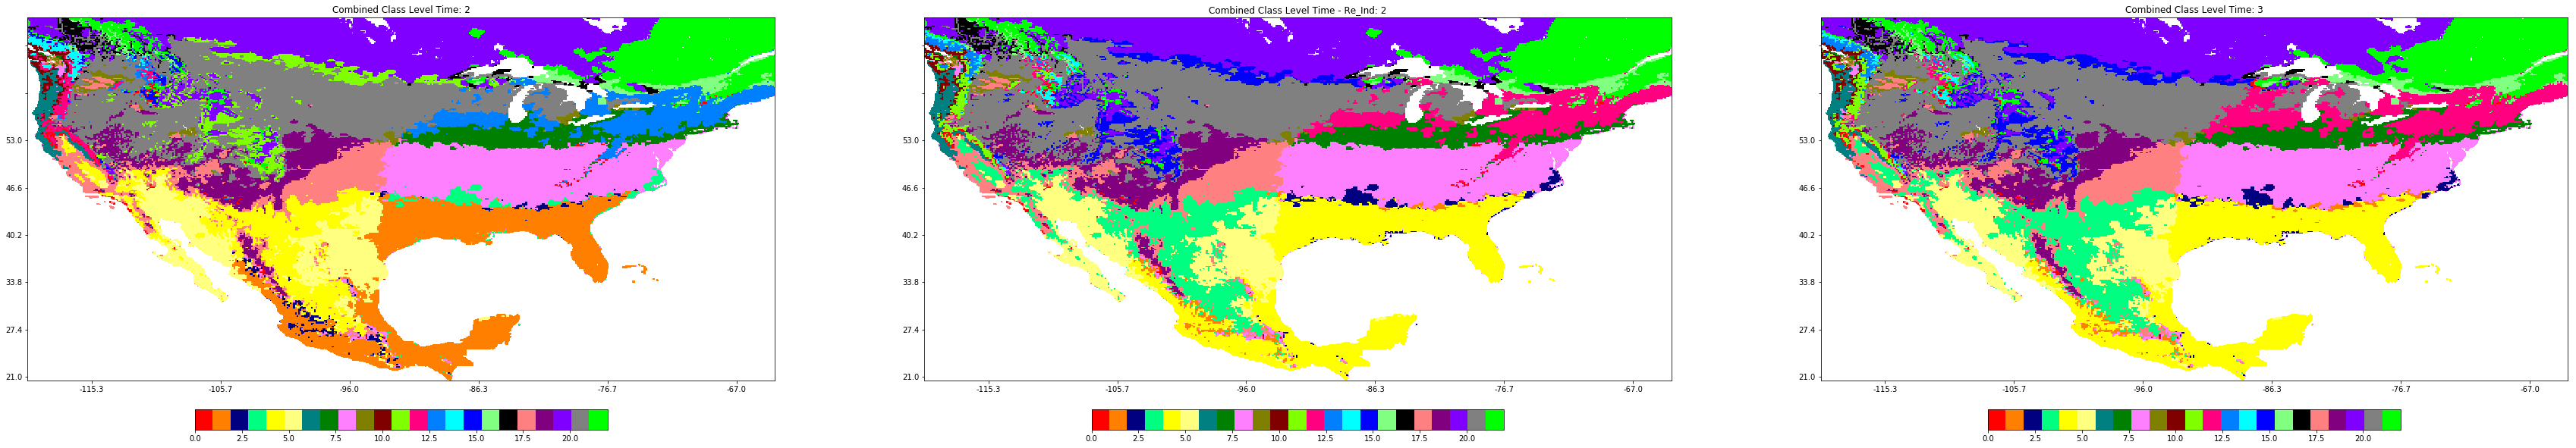

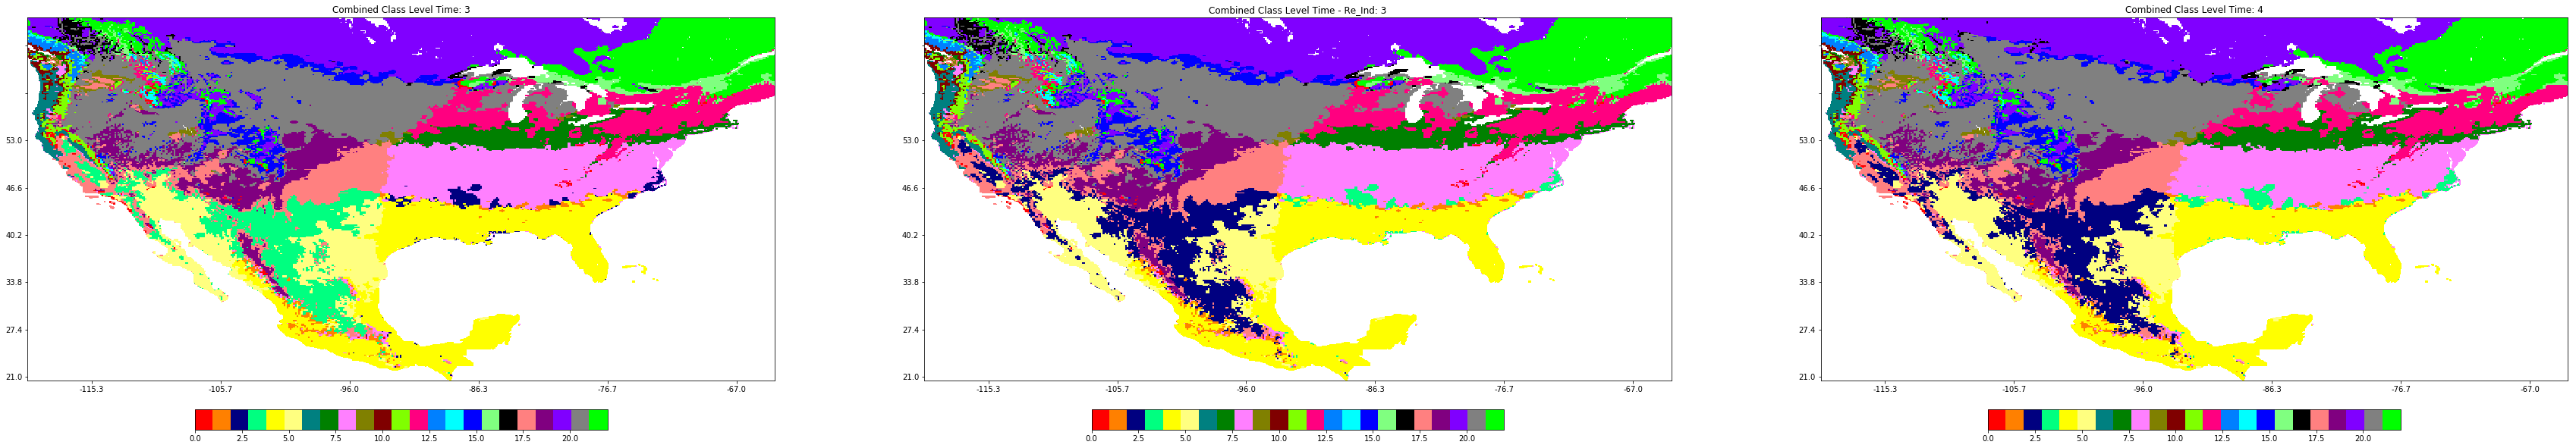

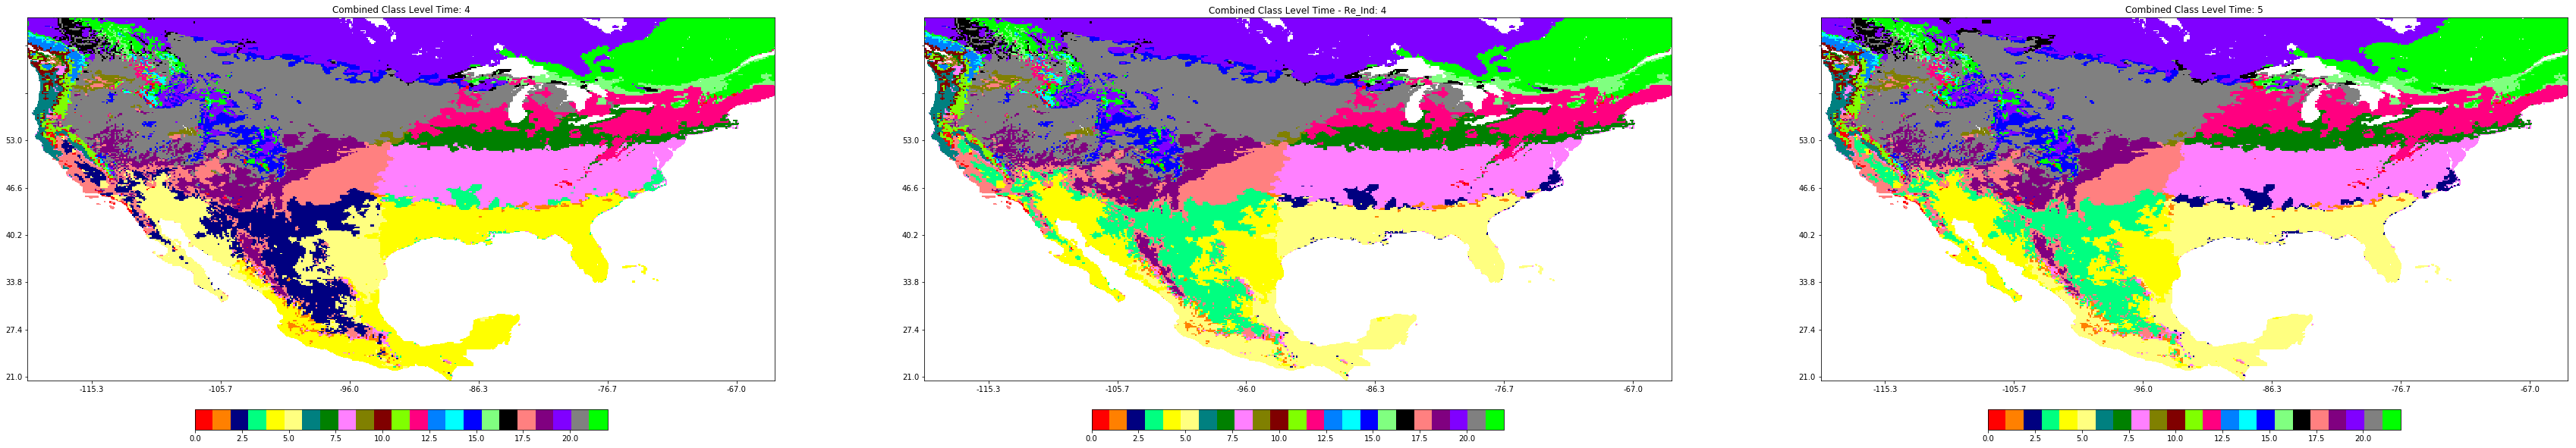

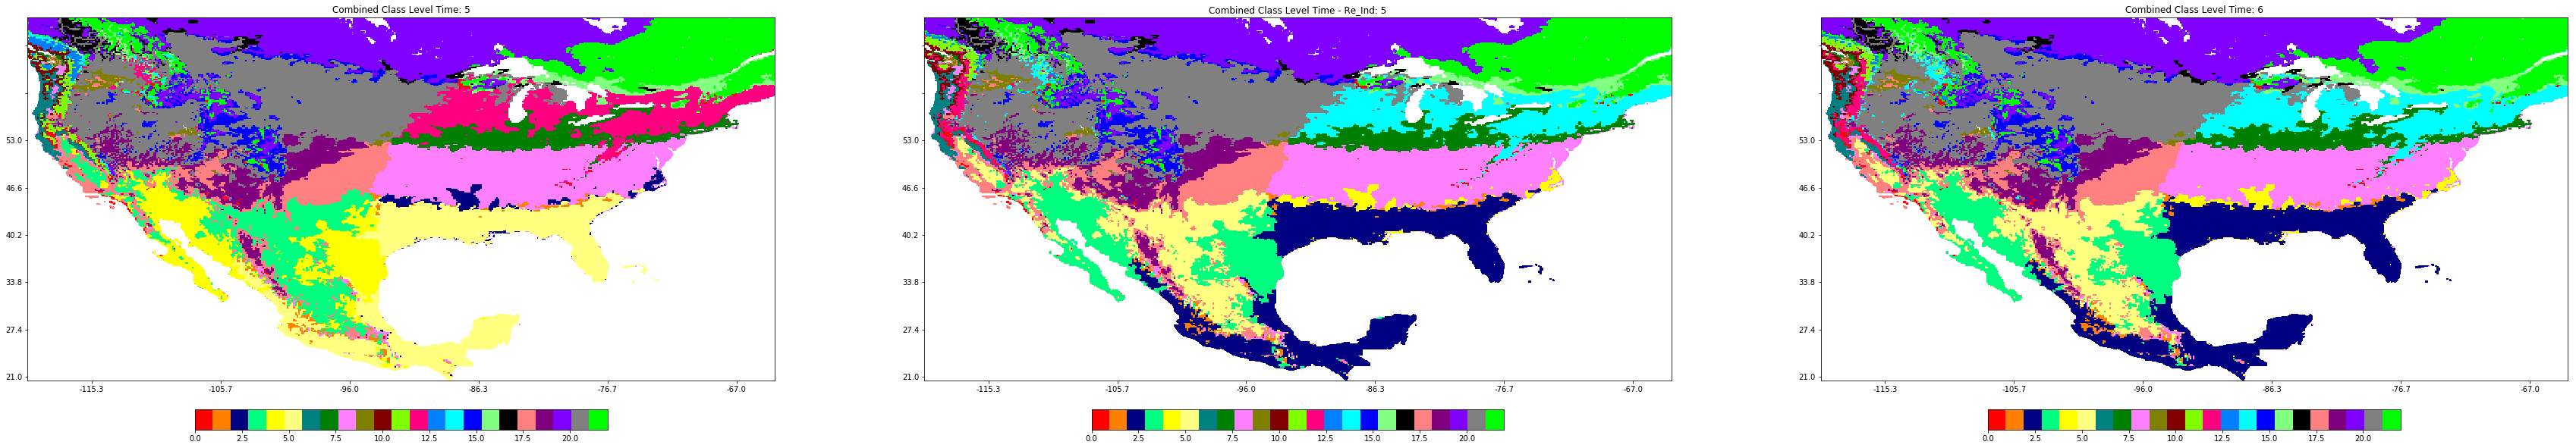

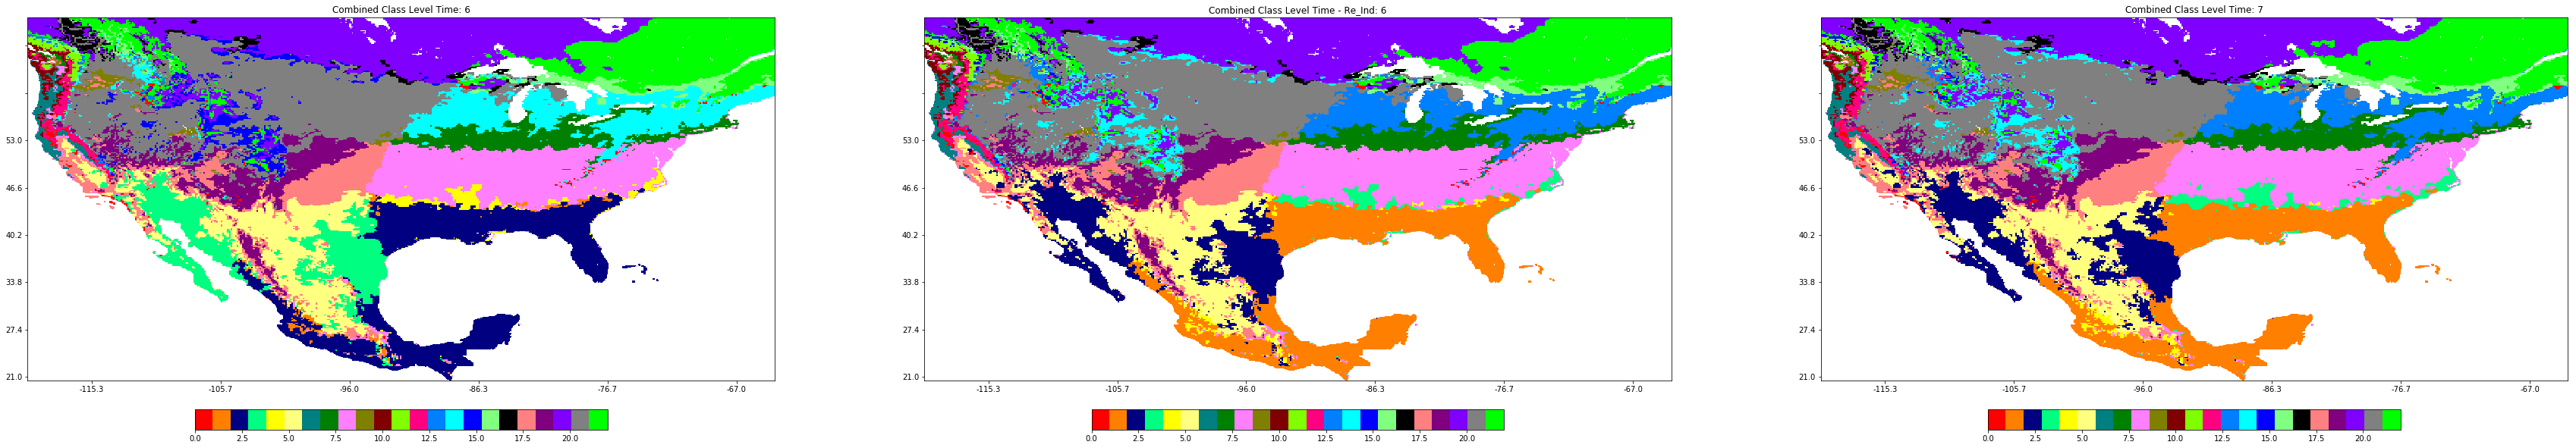

In [1104]:
#Here we plot the initial clustering, the clustering after reindex, and the next time
for i in range(num_clusterings-1):
    
    f, ax = plt.subplots(figsize=(60, 10), ncols=3, nrows=1)
    
    ###
    #First plot is the regular combined classes:
    ###
    
    number_labels = np.nanmax(label_sets[()][i])    
    cmap = color.ListedColormap(colormap)
            #Plot Prec
    p0 = ax[0].pcolormesh(ds.lon, ds.lat, plot_sets[i], vmin=0, vmax=number_labels, cmap=cmap)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    plt.colorbar(p0, ax=ax[0], orientation='horizontal',
                     pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
    ax[0].set_title('Combined Class Level Time: ' + str(i))

    ax[0].set_xticklabels(lon_space, minor=False)
    ax[0].set_yticklabels(lat_space, minor=False)
    #####
    #The second plot is the re_ind versions
    #####
    
    number_labels = np.nanmax(compare_label[i])    
    cmap = color.ListedColormap(colormap)
            #Plot Prec
    p0 = ax[1].pcolormesh(ds.lon, ds.lat, compare_label[i], vmin=0, vmax=number_labels, cmap=cmap)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    plt.colorbar(p0, ax=ax[1], orientation='horizontal',
                     pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
    ax[1].set_title('Combined Class Level Time - Re_Ind: ' + str(i))

    ax[1].set_xticklabels(lon_space, minor=False)
    ax[1].set_yticklabels(lat_space, minor=False)

    #####
    #Last is the regular combined class of next time:
    #####
    
    number_labels = np.nanmax(label_sets[()][i+1])    
    cmap = color.ListedColormap(colormap)
            #Plot Prec
    p0 = ax[2].pcolormesh(ds.lon, ds.lat, plot_sets[i+1], vmin=0, vmax=number_labels, cmap=cmap)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    plt.colorbar(p0, ax=ax[2], orientation='horizontal',
                     pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
    ax[2].set_title('Combined Class Level Time: ' + str(i+1))

    ax[2].set_xticklabels(lon_space, minor=False)
    ax[2].set_yticklabels(lat_space, minor=False)
    
    plt.show()

# Plot where biome has shifted

In [1118]:
#Compute Biome Shift:

biome_shift = {}
for i in range(num_clusterings-1):
    biome_shift[i] = plot_sets[i+1] - compare_label[i]
    biome_shift[i][biome_shift[i] !=0] =1
    biome_shift[i] = biome_shift[i] + nan_mask_slice

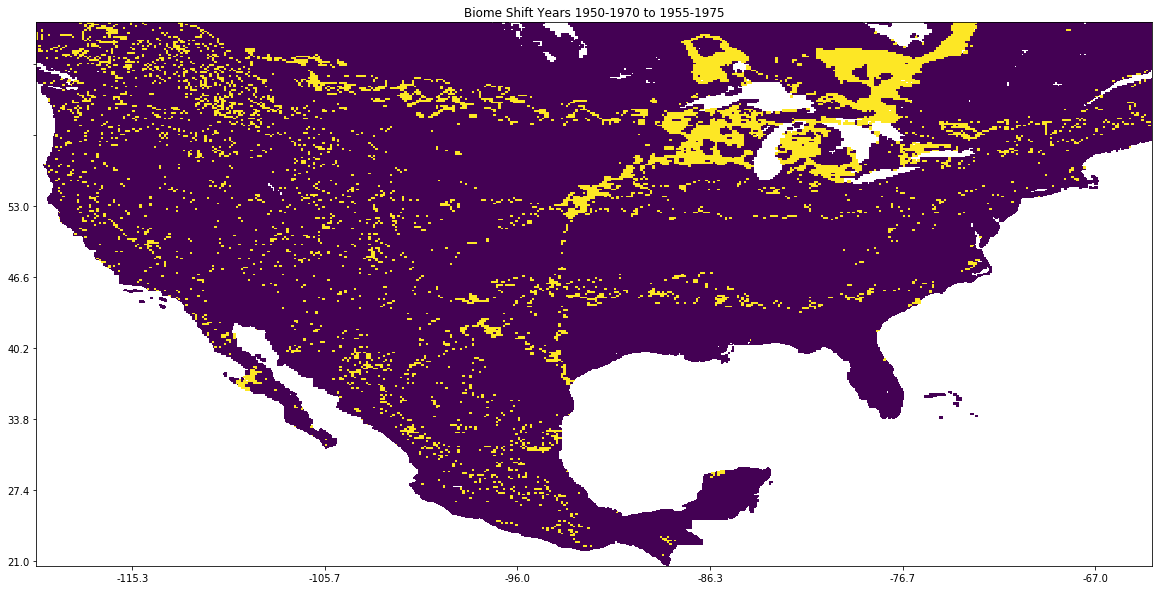

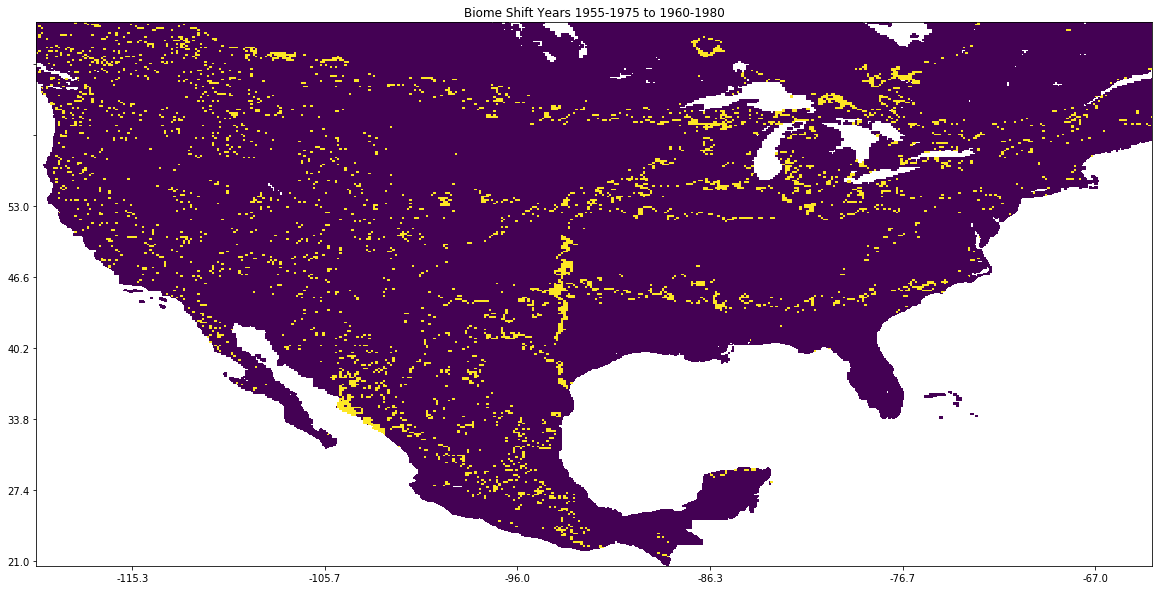

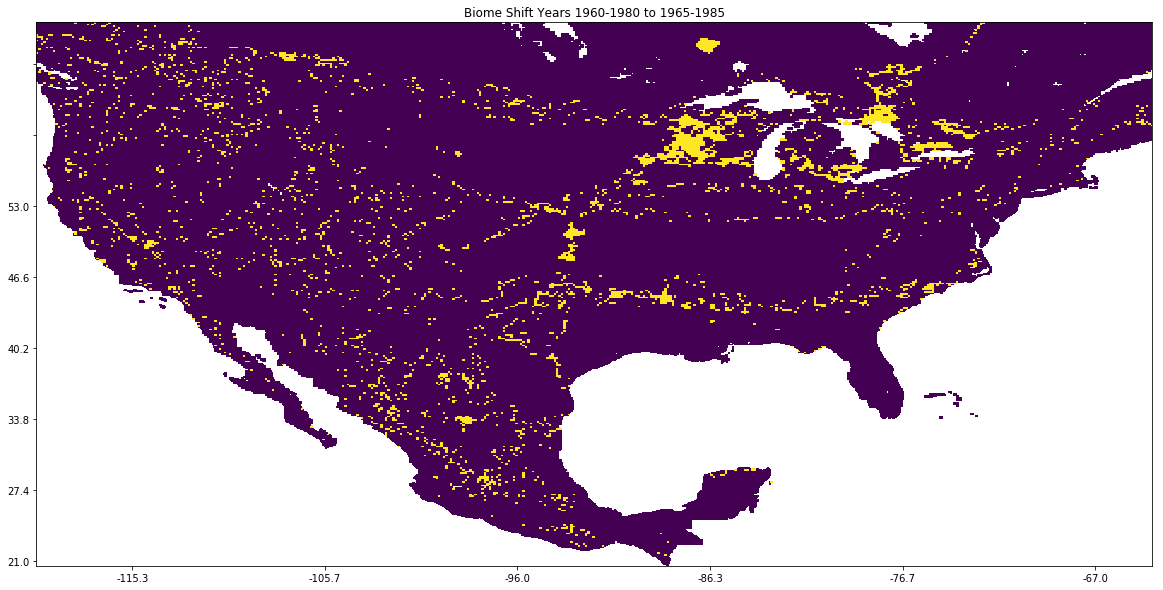

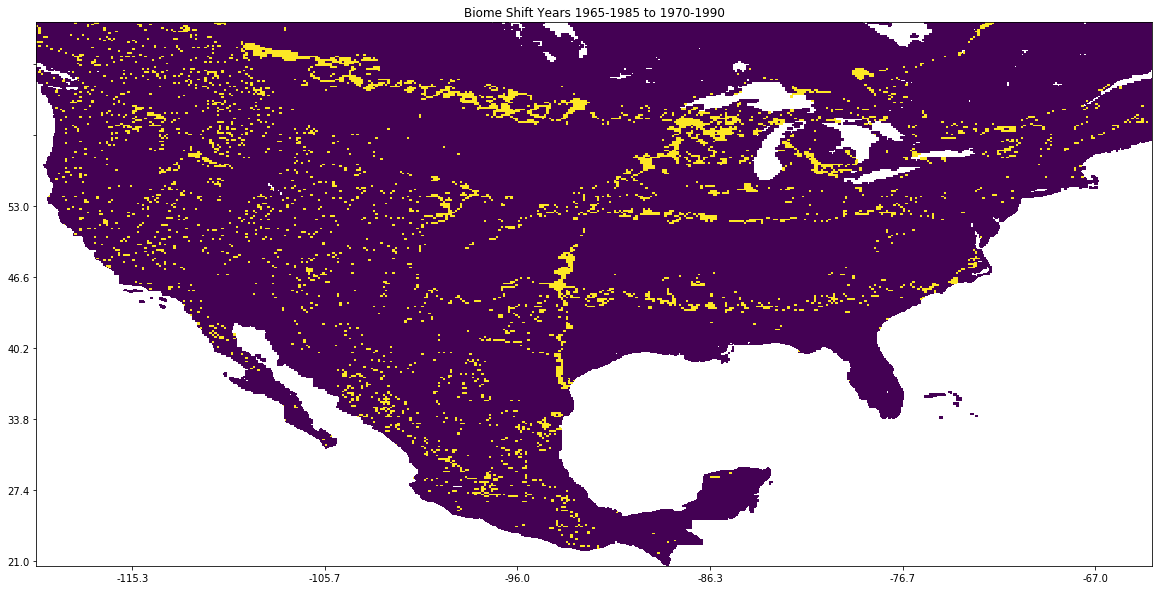

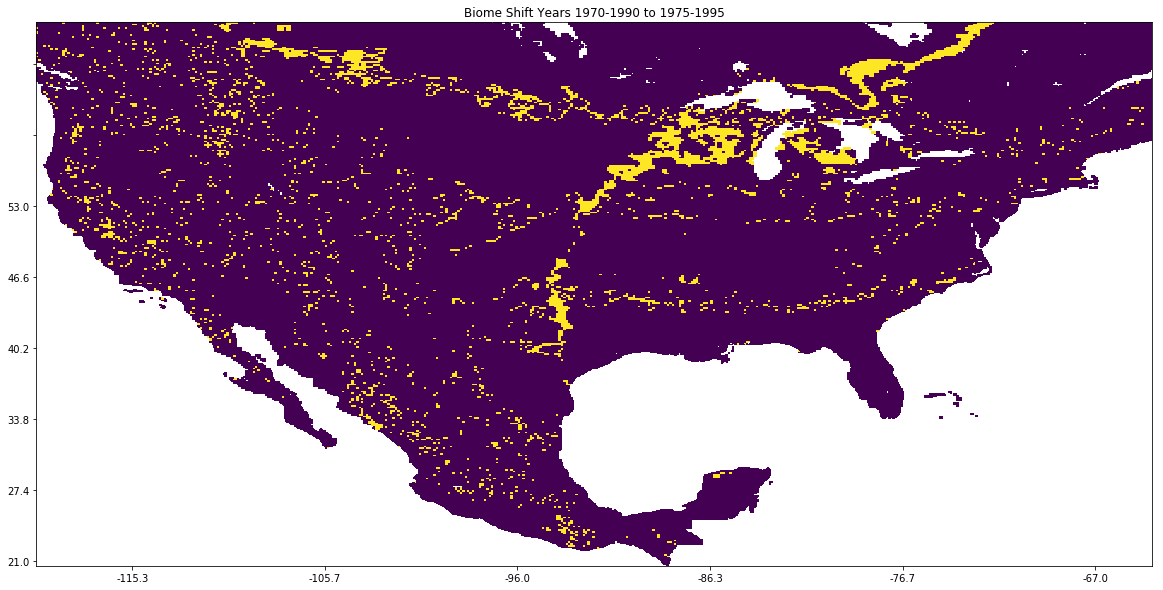

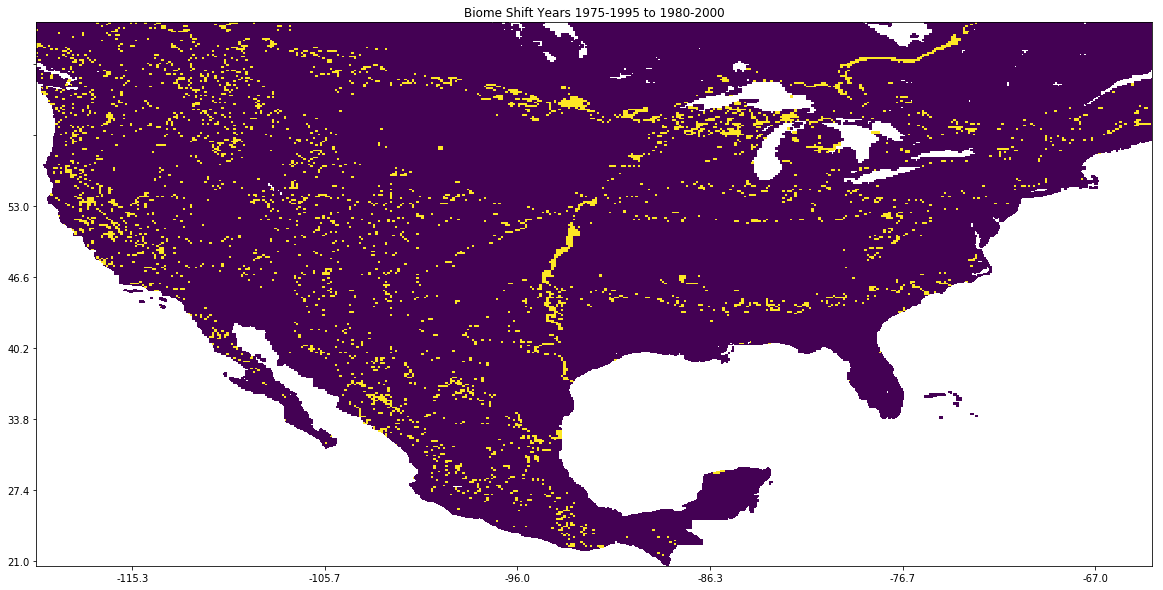

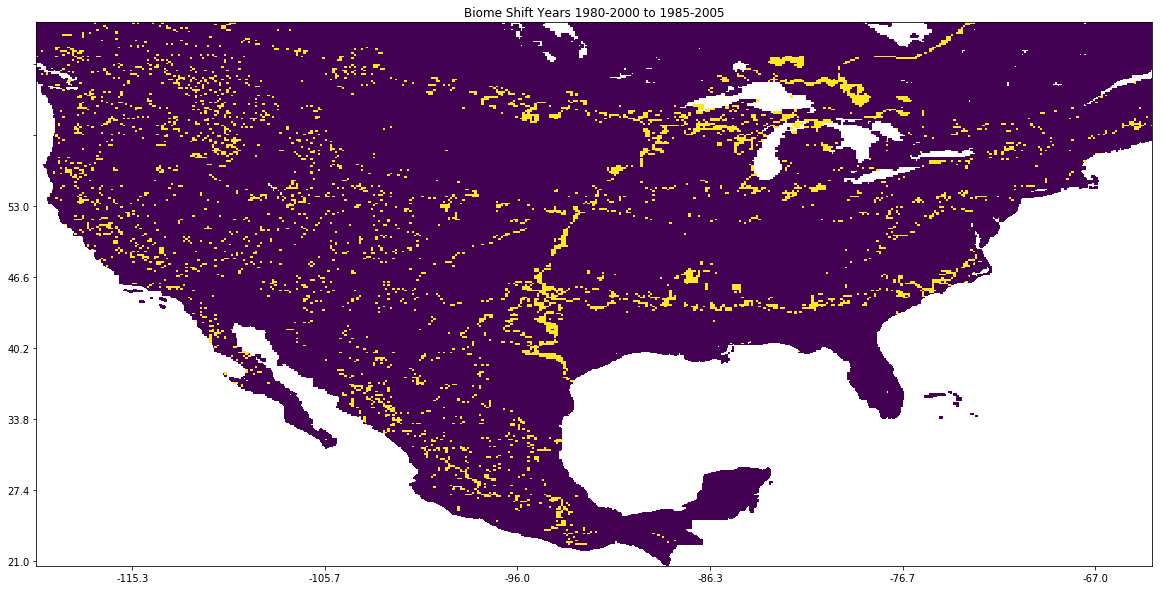

In [1127]:
#Plot the biome shift
for i in range(num_clusterings-1):
    
    f, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)
    
    ###
    #First plot is the regular combined classes:
    ###
    
    number_labels = 1
    cmap = color.ListedColormap(colormap)
            #Plot Prec
    p0 = ax.pcolormesh(ds.lon, ds.lat, biome_shift[i], vmin=0, vmax=number_labels)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    #plt.colorbar(p0, ax=ax, orientation='horizontal',
    #                 pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
    ax.set_title("Biome Shift Years " + str(1950+5*i) + "-" + str(1970 +5*i) + " to " + str(1955+5*i) + "-" + str(1975 +5*i))

    ax.set_xticklabels(lon_space, minor=False)
    ax.set_yticklabels(lat_space, minor=False)
    #####
    #The second plot is the re_ind versions
    #####
    

    
    plt.show()

## First versus last time:

In [1128]:
E = cluster_tracking(t_loc[0],t_loc[7])

Class: 0.0
Class: 1.0
Class: 2.0
Class: 3.0
Class: 4.0
Class: 5.0
Class: 6.0
Class: 7.0
Class: 8.0
Class: 9.0
Class: 10.0
Class: 11.0
Class: 12.0
Class: 13.0
Class: 14.0
Class: 15.0
Class: 16.0
Class: 17.0
Class: 18.0
Class: 19.0
Class: 20.0
Class: 21.0
Class: 22.0
Class: 23.0


Before


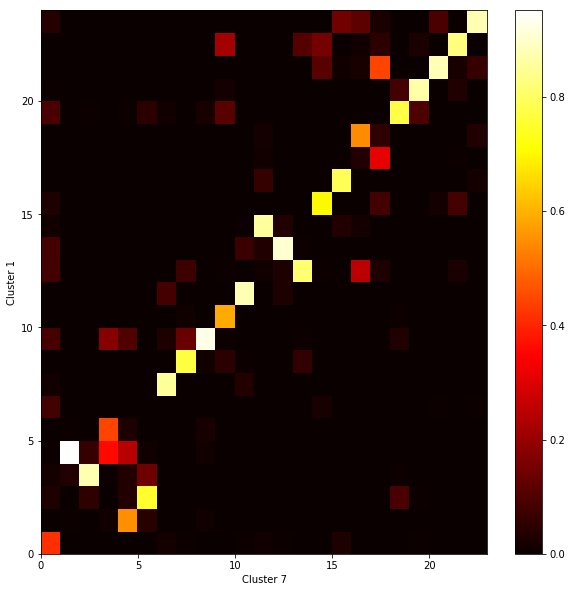

After


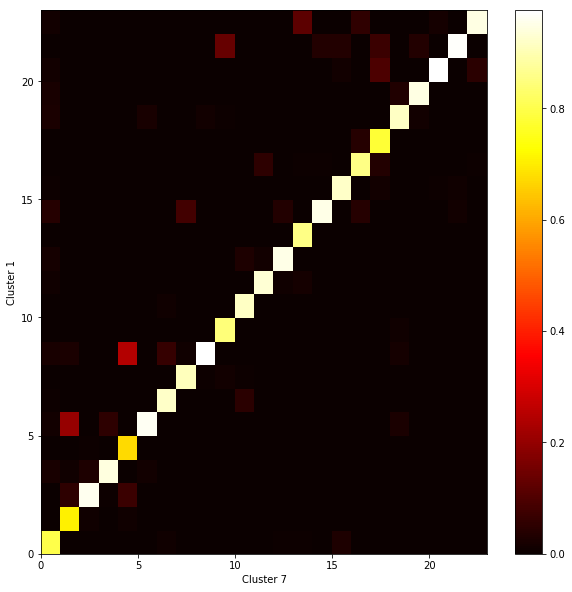

In [1131]:
ind_last = np.argmax(E,axis=1)
#re_ind_last = ind
ordered_last = E[:,ind_last]
    
print("Before")
    
plt.figure(figsize=(20,10))
p0= plt.pcolormesh(E, cmap="hot")
plt.colorbar(p0)
plt.ylabel("Cluster " + str(1))
plt.xlabel("Cluster " + str(7))
plt.show()
    
print("After")
    
plt.figure(figsize=(20,10))
p= plt.pcolormesh(ordered, cmap="hot")
plt.colorbar(p)
plt.ylabel("Cluster " + str(1))
plt.xlabel("Cluster " + str(7))
plt.show()

In [1134]:
temp_ind = np.insert(ind_last,0,-1)
temp_label = np.copy(label_sets[()][0])
save_unique = np.copy(np.unique(label_sets[()][0]))
for i in range(np.unique(label_sets[()][0]).size):
        #replace the class i in j'th time chunk with the new labels
    temp_label[label_sets[()][0] == np.unique(save_unique[i])] = temp_ind[i] 
               
final_ordered = temp_label+nan_mask_slice

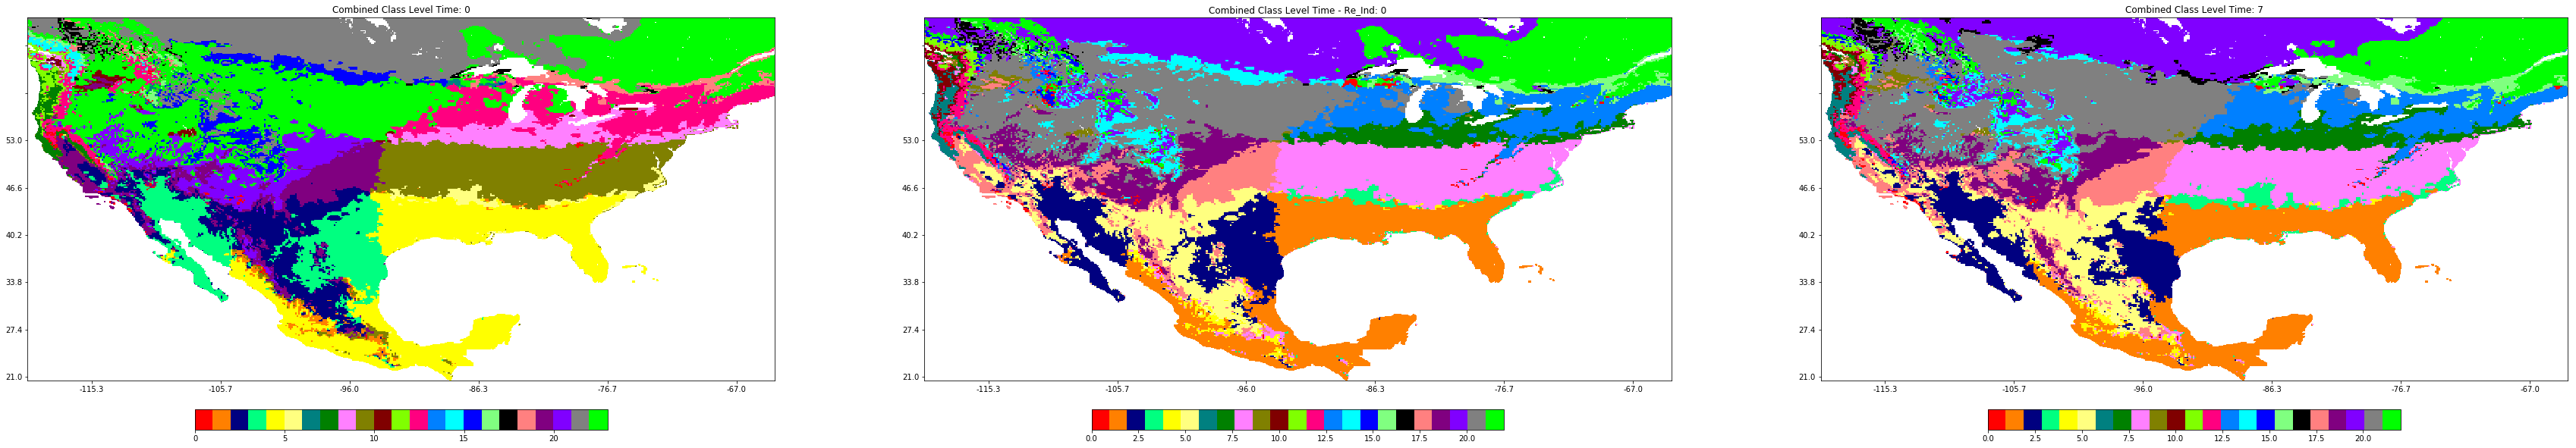

In [1143]:
f, ax = plt.subplots(figsize=(60, 10), ncols=3, nrows=1)
    
    ###
    #First plot is the regular combined classes:
    ###
    
number_labels = np.nanmax(label_sets[()][0])    
cmap = color.ListedColormap(colormap)
            #Plot Prec
p0 = ax[0].pcolormesh(ds.lon, ds.lat, plot_sets[0], vmin=0, vmax=number_labels, cmap=cmap)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
plt.colorbar(p0, ax=ax[0], orientation='horizontal',
                     pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
ax[0].set_title('Combined Class Level Time: ' + str(0))

ax[0].set_xticklabels(lon_space, minor=False)
ax[0].set_yticklabels(lat_space, minor=False)
    #####
    #The second plot is the re_ind versions
    #####
    
number_labels = np.nanmax(final_ordered)    
cmap = color.ListedColormap(colormap)
            #Plot Prec
p0 = ax[1].pcolormesh(ds.lon, ds.lat, final_ordered, vmin=0, vmax=number_labels, cmap=cmap)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
plt.colorbar(p0, ax=ax[1], orientation='horizontal',
                     pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
ax[1].set_title('Combined Class Level Time - Re_Ind: ' + str(0))

ax[1].set_xticklabels(lon_space, minor=False)
ax[1].set_yticklabels(lat_space, minor=False)

    #####
    #Last is the regular combined class of next time:
    #####
    
number_labels = np.nanmax(label_sets[()][7])    
cmap = color.ListedColormap(colormap)
            #Plot Prec
p0 = ax[2].pcolormesh(ds.lon, ds.lat, plot_sets[7], vmin=0, vmax=number_labels, cmap=cmap)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
plt.colorbar(p0, ax=ax[2], orientation='horizontal',
                     pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
ax[2].set_title('Combined Class Level Time: ' + str(7))

ax[2].set_xticklabels(lon_space, minor=False)
ax[2].set_yticklabels(lat_space, minor=False)
    
plt.show()

In [1138]:
biome_final = plot_sets[7] - final_ordered
biome_final[biome_final !=0] =1
biome_final = biome_final + nan_mask_slice

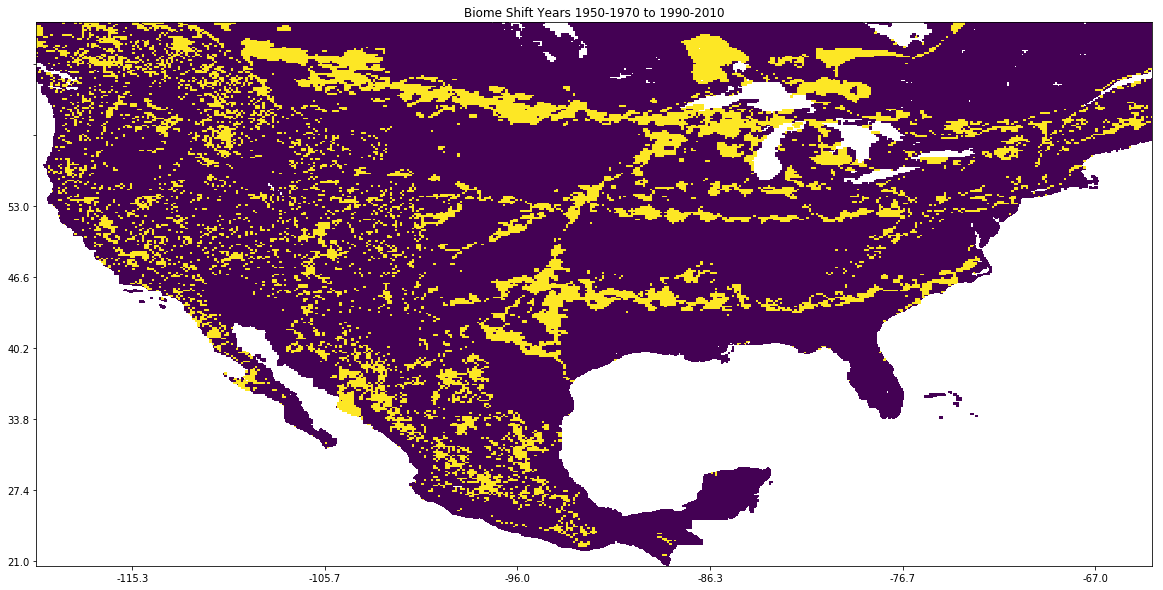

In [1142]:
f, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)
    
    ###
    #First plot is the regular combined classes:
    ###
    
number_labels = 1
cmap = color.ListedColormap(colormap)
            #Plot Prec
p0 = ax.pcolormesh(ds.lon, ds.lat, biome_final, vmin=0, vmax=number_labels)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    #plt.colorbar(p0, ax=ax, orientation='horizontal',
    #                 pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
ax.set_title("Biome Shift Years " + str(1950) + "-" + str(1970) + " to " + str(1955+5*7) + "-" + str(1975 +5*7))

ax.set_xticklabels(lon_space, minor=False)
ax.set_yticklabels(lat_space, minor=False)

plt.show()